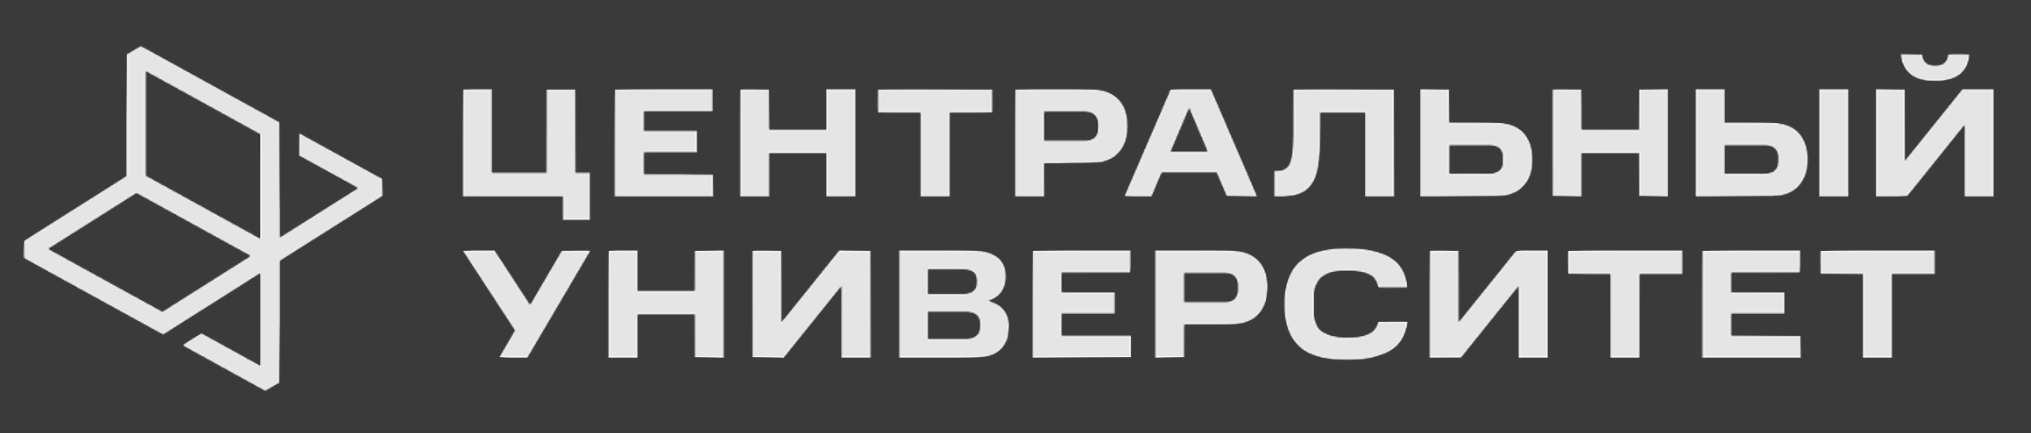

# Семинар 8. Generative models.

## Plan:
0. Data preparation
1. Autoencoders
    - Vanilla AE
    - Denoising Autoencoder(DAE)
    - Variational Autoencoder(VAE)
        - KL divergence
        - ELBO
        - reparametrization trick
        - implementation
        - latent space interpolation
2. GANs
    - DCGAN architecture
    - mode collapse
    - generative quality assessment
    
3. Generation quality assessment
    - IS
    - FID
    - LPIPS

# 0. Data preparation

Today we will work with [The Quick, Draw! Dataset](https://github.com/googlecreativelab/quickdraw-dataset)

The full set totals to 5 million 365 categories.

For simplicity we picked only 10 classes.

Let's define custom dataset class for our data. By that means, we should overload two methods:
- `__getitem__(self, idx)`, returns dataset entry
- `__len(self)__`, returns dataset size

In [ ]:
# !unzip mini_quickdraw.zip
!ls mini_quickdraw

class_names.npy
test_images.npy
train_images.npy
train_labels.npy
val_images.npy
val_labels.npy


In [ ]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

class ImageDataset(Dataset):
    def __init__(self, folder, split=None, transform=None):
        # call parent contruction method
        super().__init__()

        self.class_names = np.loadtxt(os.path.join(folder, 'class_names.npy'), dtype=str)
        self.img_dim = 28

        if split.lower() not in ['train', 'val', 'test']:
            raise Exception('wrong split encountered')

        self.images = np.load(os.path.join(folder, f'{split.lower()}_images.npy')).astype(np.uint8)
        self.labels = np.load(os.path.join(folder, f'{split.lower()}_labels.npy')) if split.lower() != 'test' else None

        self.transform = transform

        print(f'{split.lower()} split loaded successfully')

    def __getitem__(self, idx):
        imgs = self.images[idx]

        if self.transform:
            imgs = self.transform(imgs.reshape(self.img_dim, self.img_dim, 1))

        return imgs, self.labels[idx] if self.labels is not None else -1

    def __len__(self):
        return len(self.images)

In [ ]:
dataset = ImageDataset(folder='mini_quickdraw', split='TRAIN')

train split loaded successfully


In [ ]:
img, label = dataset[0]
img.shape, label.shape

((784,), ())

Here we see that our dataset consists of flattened images. Thus, the only transforms we will use are reshaping and `ToTensor`.

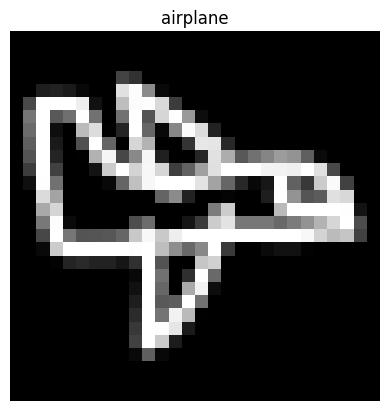

In [ ]:
import matplotlib.pyplot as plt

plt.axis('off')
plt.imshow(img.reshape(dataset.img_dim, dataset.img_dim, 1), cmap='gray')
plt.title(dataset.class_names[label])
plt.show()

Let's move on, finish data preparation and start with the very basic autoencoder architecture.

In [ ]:
dataset.img_dim

28

In [ ]:
import torchvision.transforms as TT

transforms = TT.Compose([
  TT.ToPILImage(), # torchvision is not designed to transform numpy
  TT.ToTensor(),
  TT.Normalize(mean=0.5, std=0.5),
  TT.Lambda(lambda x: x.flatten())
])

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [ ]:
train_dataset = ImageDataset(folder='mini_quickdraw', split='TRAIN', transform=transforms)
val_dataset = ImageDataset(folder='mini_quickdraw', split='VAL', transform=transforms)
test_dataset = ImageDataset(folder='mini_quickdraw', split='TEST', transform=transforms)

len(train_dataset), len(val_dataset), len(test_dataset)

train split loaded successfully
val split loaded successfully
test split loaded successfully


(100000, 15000, 1000)

Test dataset contains 100 samples of each class and has no labels

In [ ]:
BATCH_SIZE = 2048

# shuffle only during training
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=2*BATCH_SIZE)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=2*BATCH_SIZE)

___

# 1. Autoencoders

Autoencoders is a broad class of models. **The main aim of autoencoder is to copy its input to its output**.

However, it's not very useful destination.

In order to bring new interesting properties, researchers came up with different modifications and heuristics, which we will discuss further.

Below we will see **Vanilla AE architecture**

![](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*UdOybs9wOe3zW8vDAfj9VA@2x.png)

Simple AE consists of:
- **encoder**, projection of *initial feature space* $\mathbb{R}^n$ into *hidden space* $\mathbb{R}^m$
- **decoder**, inverse projection $\mathbb{R}^m \rightarrow \mathbb{R}^n$
- **reconstruction loss**, objective function, punishing for errors in information recovery

Though this picture might be misleading, meaning that it's not necessary $m < n$

AEs could be devided into 2 groups:
- $m > n$, **overcomplete**
- $m < n$, **undercomplete**

We stick to the latter class because it is widely used for dimensionality reduction.

___

## 1.1 Vanilla AE

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*bY_ShNK6lBCQ3D9LYIfwJg@2x.png)

Recostruction error is a simple **Mean Squared Error(MSE)** is our case.

In [ ]:
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, c_in, c_out, last_layer=False):
        super().__init__()

        self.last_layer = last_layer

        self.fc = nn.Linear(
            in_features=c_in,
            out_features=c_out
        )

        self.norm = nn.BatchNorm1d(
            num_features=c_out
        )
        self.act = nn.ReLU()

    def forward(self, x):

        if self.last_layer:
            return self.fc(x)

        return self.act(self.norm(self.fc(x)))


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            Block(784, 512),
            Block(512, 256),
            Block(256, 128),
            Block(128, 64),
            Block(64, 32, last_layer=True),
        )

        self.decoder = nn.Sequential(
            Block(32, 64),
            Block(64, 128),
            Block(128, 256),
            Block(256, 512),
            Block(512, 784, last_layer=True),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = torch.tanh(x)
        return x

    def get_latent(self, x):
        return self.encoder(x)

In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda', index=0)

In [ ]:
model = AutoEncoder().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

Let's check latent(*hidden*) representation in advance:

We will project $m$-dimensional vectors into interpretable 2D plane.

One can use [PCA](https://scikit-learn.org/1.5/modules/generated/sklearn.decomposition.PCA.html) OR [TSNE](https://scikit-learn.org/1.5/modules/generated/sklearn.manifold.TSNE.html) method from `scikit-learn`, while we pick the latter.

In [ ]:
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm

In [ ]:
def plot_test_clusters(model=None, device=None):
    tsne = TSNE()
    model.eval()

    latents = [
        model.get_latent(x.to(device)).detach().cpu()
        for x, _ in tqdm(test_loader)
    ]

    latents = torch.cat(latents, dim=0).numpy()

    latents_2d = tsne.fit_transform(latents)
    plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=np.arange(10).repeat(100), cmap='tab10')
    plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

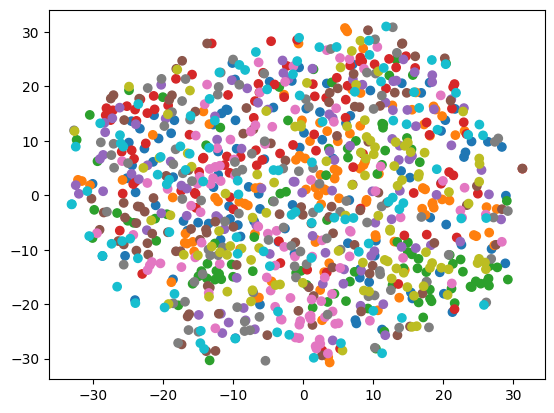

In [ ]:
plot_test_clusters(
    model=model,
    device=DEVICE
)

In [ ]:
from IPython.display import clear_output

def train_model(model=None, n_epochs=1, optimizer=None, device=None, noise=0):
    losses = []
    model.train()

    for epoch_id in tqdm(range(n_epochs), desc='train loop', leave=True):
        for image, _ in tqdm(train_loader, desc='train loop', leave=False):

            # refresh grads
            optimizer.zero_grad()

            # froward pass
            image = image.to(DEVICE)

            # optional noise injection
            out = model(image + torch.randn_like(image) * noise)

            loss = criterion(out, image)

            # calculate grads
            loss.backward()

            # make gradient descent iteration
            optimizer.step()

            # log loss history
            losses.append(loss.item())

        # clear plot
        clear_output(wait=True)

        plt.plot(losses)
        plt.title(f'epoch #{epoch_id+1}/{n_epochs}')
        plt.show()

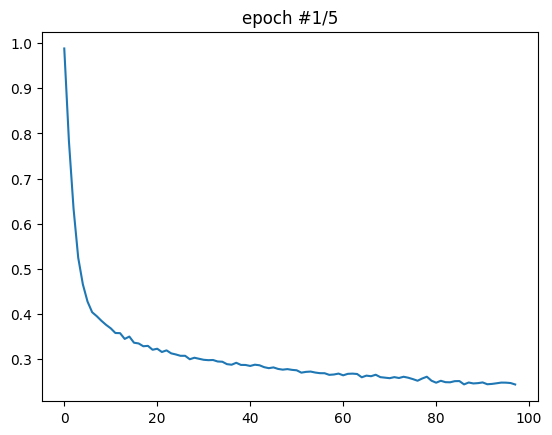

train loop:   0%|          | 0/98 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
train_model(
    model=model,
    optimizer=optimizer,
    device=DEVICE,
    n_epochs=5
)

  0%|          | 0/1 [00:00<?, ?it/s]

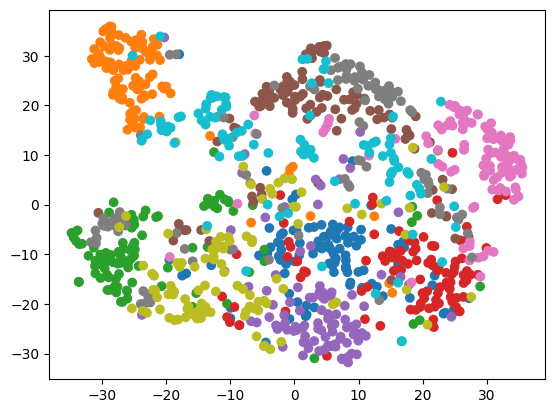

In [ ]:
plot_test_clusters(
    model=model,
    device=DEVICE
)

We see that latent features gain somewhat structure.

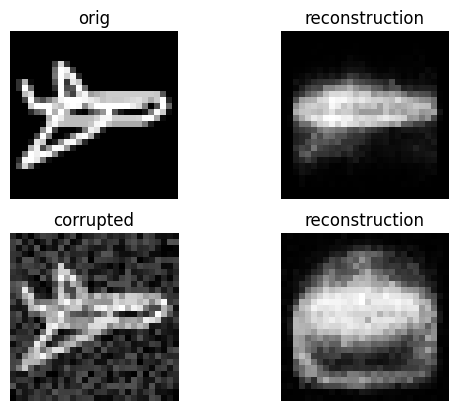

In [ ]:
_, axes = plt.subplots(ncols=2, nrows=2)

model.eval()

img_sample = val_dataset[0][0]
corr_sample = img_sample + torch.rand_like(img_sample)

for i, (img, lab) in enumerate(zip([img_sample, corr_sample], ['orig', 'corrupted'])):

    axes[i][0].imshow(img.reshape(28, 28, 1), cmap='gray')
    axes[i][0].set_title(lab)
    axes[i][0].axis('off')

    output = model(img.to(DEVICE).unsqueeze(0)).detach().cpu()

    axes[i][1].imshow(output.reshape(28, 28, 1), cmap='gray')
    axes[i][1].set_title('reconstruction')
    axes[i][1].axis('off')

We see that a small perturbation of input dramatically damages recontruction.

Thus, we faced second destination of autoencoders: effective representation of latents, so that it's prone to small corruptions.

___

## 1.2 Denoising AE

There is a big class of **Regularized Autoencoders**:

Such autoencoders use a loss function that encourages the model to have other properties *besides the ability to copy its input to its output*:

* **Sparse** autoencoder training criterion involves a sparsity penalty $\Omega(\boldsymbol{h})$:


    $L(\boldsymbol{x}, g(f(\boldsymbol{x})))+\Omega(\boldsymbol{h})$

    $f$, $g$ - encoder/decoder

* **Contractive** autoencoder has a penalty in the latent space:

    $\Omega(\boldsymbol{h}, \boldsymbol{x})=\lambda \sum_i\left\|\nabla_{\boldsymbol{x}} h_i\right\|^2$

* **Denoising** autoencoder optimizes loss, which very similar to vanilla, except for it aims to reconstruct $\boldsymbol{x}$ from $\tilde{\boldsymbol{x}}$ with injected noise, $\mathcal{N}(0, \sigma)$ for example.

     $L(\boldsymbol{x}, g(f(\tilde{\boldsymbol{x}})))$

* **Variational** autoencoder:

    ..will be discussed later

Let's discuss DAE. The authors of this approach actually invented dropout heuristic(they called it *noise*) before it actually was published, though contemporary architectures also using it together with the noise of different nature(masking noise, Gaussian noise, salt-and-pepper noise, etc.)

In [ ]:
class DenoisingBlock(nn.Module):
    def __init__(self, *args, noise=0, first_layer=False, **kwargs):
        super().__init__()

        self.block = Block(*args, **kwargs)
        self.noise = noise

        self.first_layer = first_layer
        self.last_layer = kwargs.pop('last_layer', False)

    def forward(self, x):

        return self.block(x)

class DenoisingAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            DenoisingBlock(784, 512, first_layer=True),
            DenoisingBlock(512, 256),
            DenoisingBlock(256, 128),
            DenoisingBlock(128, 64),
            DenoisingBlock(64, 32, last_layer=True),
        )

        self.decoder = nn.Sequential(
            DenoisingBlock(32, 64, first_layer=True),
            DenoisingBlock(64, 128),
            DenoisingBlock(128, 256),
            DenoisingBlock(256, 512),
            DenoisingBlock(512, 784, last_layer=True),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = torch.tanh(x)
        return x

    def get_latent(self, x):
        return self.encoder(x)

In [ ]:
model = DenoisingAutoEncoder().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  0%|          | 0/1 [00:00<?, ?it/s]

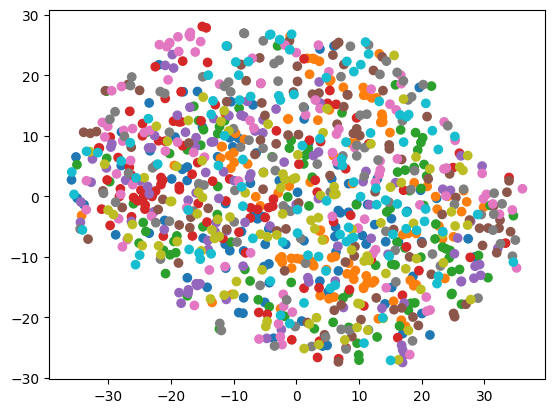

In [ ]:
plot_test_clusters(
    model=model,
    device=DEVICE
)

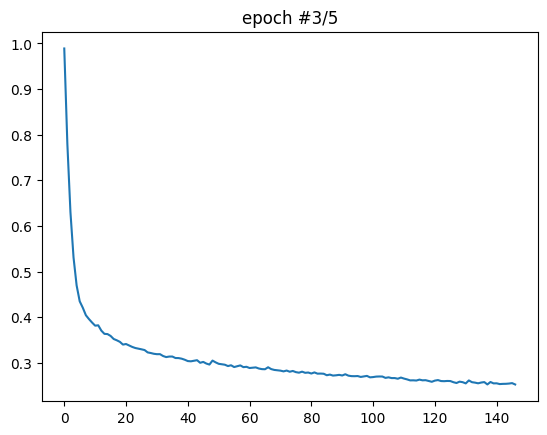

train loop:   0%|          | 0/49 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
train_model(
    model=model,
    optimizer=optimizer,
    device=DEVICE,
    n_epochs=5,
    noise=1
)

  0%|          | 0/1 [00:00<?, ?it/s]

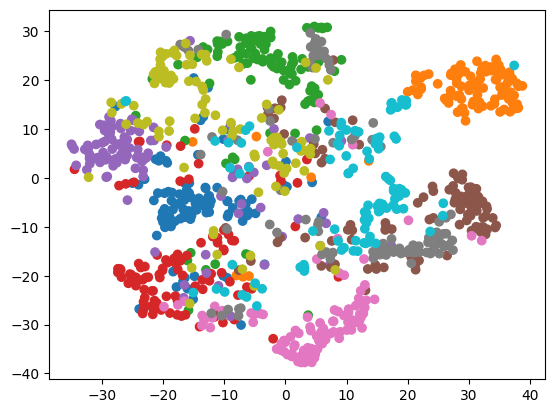

In [ ]:
plot_test_clusters(
    model=model,
    device=DEVICE
)

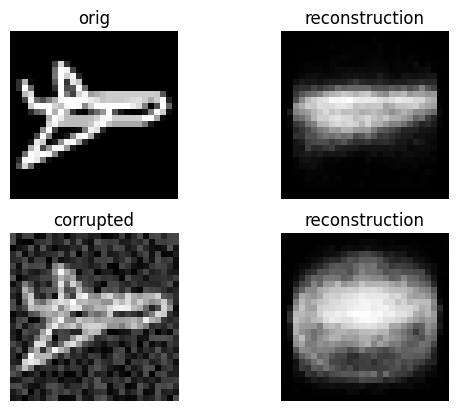

In [ ]:
_, axes = plt.subplots(ncols=2, nrows=2)

model.eval()

img_sample = val_dataset[0][0]
corr_sample = img_sample + torch.rand_like(img_sample)

for i, (img, lab) in enumerate(zip([img_sample, corr_sample], ['orig', 'corrupted'])):

    axes[i][0].imshow(img.reshape(28, 28, 1), cmap='gray')
    axes[i][0].set_title(lab)
    axes[i][0].axis('off')

    output = model(img.to(DEVICE).unsqueeze(0)).detach().cpu()

    axes[i][1].imshow(output.reshape(28, 28, 1), cmap='gray')
    axes[i][1].set_title('reconstruction')
    axes[i][1].axis('off')

Let's inspect latent feature distribution and compare with random gaussian noise.

In [ ]:
img_sample = val_dataset[0][0]

latent = model.get_latent(img_sample.unsqueeze(0).to(DEVICE)).detach().cpu()

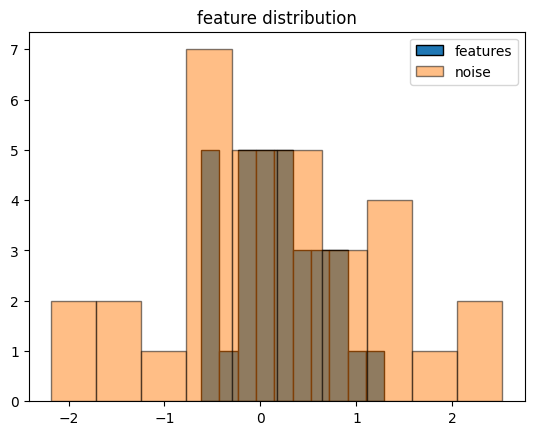

In [ ]:
plt.hist(latent.view(-1), edgecolor='k', label='features')
plt.hist(torch.randn_like(latent.view(-1) * 5e-1), edgecolor='k', label='noise', alpha=0.5)

plt.title('feature distribution')
plt.legend()
plt.show()

We see that they look similar, but variances slightly differ.
Could we sample from it though?

Let's compare what we can achieve from average feature representation of some class

In [ ]:
model.eval()
pass

In [ ]:
# every 100 samples correspond to same class

tmp_features = []

for i in tqdm(range(100)):
    feat = model.get_latent(test_dataset[i+100][0].unsqueeze(0).to(DEVICE)).detach().cpu()

    tmp_features.append(feat)

average_triangle_feature = torch.mean(torch.stack(tmp_features), dim=0)
average_triangle_feature.shape

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([1, 32])

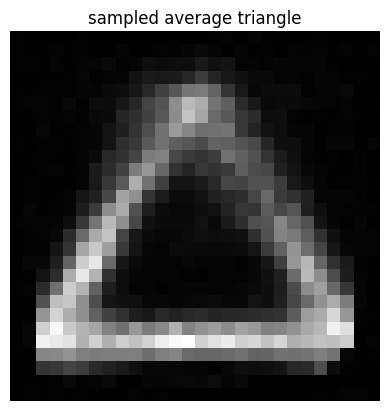

In [ ]:
sampled_triangle_vector = torch.tanh(model.decoder(average_triangle_feature.to(DEVICE))).detach().cpu()

plt.axis('off')
plt.title('sampled average triangle')
plt.imshow(sampled_triangle_vector.reshape(28, 28, 1), cmap='gray')
plt.show()

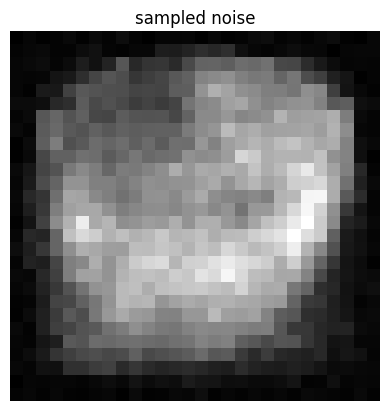

In [ ]:
noise_feature = torch.randn_like(average_triangle_feature) * 1e-5

sampled_noise_vector = torch.tanh(model.decoder(noise_feature.to(DEVICE))).detach().cpu()

plt.axis('off')
plt.title('sampled noise')
plt.imshow(sampled_noise_vector.reshape(28, 28, 1), cmap='gray')
plt.show()

Failure.

We adapted our architecture towards input features variations.

If we want to trace latent space to generate diverse examples of same entity(class), one should optimize latent space directly.

___

## 1.3 Variational AE(VAE)

### **Motivation**

![](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*83S0T8IEJyudR_I5rI9now@2x.png)

Previously, we learned mapping from input feature space $\mathbb{R^n}$ to latent space $\mathbb{R}^m$, $m <n$

Now we will try to learn $\mathbb{R^n} \rightarrow \mathcal{N(0, 1)}$ with zero mean and identity covariance matrix.

*Why?*

Because this distribution has good properties, its parameters allow us to tune both:
- spread of points of same class(intra-class distance)
- distance to different point clusters(inter-class distance)

So that it guarantees the regular latent space

___

### **Overview**

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*Q5dogodt3wzKKktE0v3dMQ@2x.png)

___

### 1.3.1 KL divergence

So far we used **MSE** to measure distance between sample and its reconstruction. Now we need to find a way to estimate difference of distributions.

Divergence of Kullback-Leibler has such intuition:

$D_{\mathrm{KL}}(P \| Q)=\sum_{x \in \mathcal{X}} P(x) \log \left(\frac{P(x)}{Q(x)}\right)$

$P, Q$ are some distributions, say target and predicted

There are some other kinds of divergences in probability theory, but KL is widely used in tasks, where we need to measure "distance" between normal distributions

Let's list some of its properties:

- $D_{\mathrm{KL}}(P \| Q) \geq 0$ - non-negativity
- $D_{\mathrm{KL}}(P \| Q) \neq D_{\mathrm{KL}}(Q \| P)$ - asymmetry

![](https://hugocisneros.com/ox-hugo/forwardvsreversedKL.jpg)

**VAE** uses reversed KL scheme.

___

### 1.3.2 ELBO

Here we discuss the whole training objective of **VAE**

Given some data, we usually try to explain it via model $f$ with some parameters $\boldsymbol{\boldsymbol{\omega}}$

Those parameters are used to approximate some function $f(\boldsymbol{\omega})$, explaining distribution some unknown distribution.

This process is done via so-called likelihood maximization:
$$\mathbb{E} f(\boldsymbol{\omega}, \boldsymbol{x})\rightarrow \max_{\omega}$$

Logarithm is a *monotonic* function, so if we apply it to some function, it doesn't change the solution. It also turns product of probabilities into a sum of logs, simplifying the task.

___

Thus, let's optimize our prior function $p(\mathbf{x})$

![](https://arxiv.org/html/2403.18103v1/extracted/5497877/pix/Figure01_VAE_states.png)

We will approximate real distributions with:
- ***encoder*** $q_\phi(\mathbf{z} \mid \mathbf{x})$

- ***decoder*** $p_\theta(\mathbf{x} \mid \mathbf{z})$

where $\mathbf{z}$ is latent and $\mathbf{x}$ input feature variables

___

$\begin{aligned} \log p(\mathbf{x})=\text { some magical steps } & =\mathbb{E}_{q_\phi(\mathbf{z} \mid \mathbf{x})}\left[\log \frac{p(\mathbf{x}, \mathbf{z})}{q_\phi(\mathbf{z} \mid \mathbf{x})}\right]+\mathbb{D}_{\mathrm{KL}}\left(q_\phi(\mathbf{z} \mid \mathbf{x}) \| p(\mathbf{z} \mid \mathbf{x})\right) \\ & \geq \mathbb{E}_{q_\phi(\mathbf{z} \mid \mathbf{x})}\left[\log \frac{p(\mathbf{x}, \mathbf{z})}{q_\phi(\mathbf{z} \mid \mathbf{x})}\right] \\ & \stackrel{\text { def }}{=} \operatorname{ELBO}(\mathbf{x}),\end{aligned}$

Here we used property of non-negativity of $\mathbb{D}_{\mathrm{KL}}$

So now we optimize $\operatorname{ELBO}(\mathbf{x})$

**ELBO** stands for **E**vidence **L**ower **Bo**und

___

$\begin{array}{rlr}\operatorname{ELBO}(\mathbf{x}) & \stackrel{\text { def }}{=} \mathbb{E}_{q_\phi(\mathbf{z} \mid \mathbf{x})}\left[\log \frac{p(\mathbf{x}, \mathbf{z})}{q_\phi(\mathbf{z} \mid \mathbf{x})}\right] & \text { definition } \\ & =\mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})}\left[\log \frac{p(\mathbf{x} \mid \mathbf{z}) p(\mathbf{z})}{q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})}\right] & p(\mathbf{x}, \mathbf{z})=p(\mathbf{x} \mid \mathbf{z}) p(\mathbf{z}) \\ & =\mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})}[\log p(\mathbf{x} \mid \mathbf{z})]+\mathbb{E}_{q_\phi(\mathbf{z} \mid \mathbf{x})}\left[\log \frac{p(\mathbf{z})}{q_{\boldsymbol{\phi}}(\mathbf{z} \mid \mathbf{x})}\right] & \text { split expectation } \\ & =\underbrace{\mathbb{E}_{q_\phi(\mathbf{z} \mid \mathbf{x})}[\log \overbrace{p_{\boldsymbol{\theta}}(\mathbf{x} \mid \mathbf{z})}^{\text {Gaussian }}]}_{\text {how good your decoder is }} \quad-\quad \underbrace{\mathbb{D}_{\mathrm{KL}}(\overbrace{q_\phi(\mathbf{z} \mid \mathbf{x})}^{\text {Gaussian }} \| \overbrace{p(\mathbf{z})}^{\text {a Gaussian }})}_{\text {how good your encoder is }} & \text { definition of KL }\end{array}$

$p(\mathbf{z})$ sampled from $\mathcal{N(0, 1)}$

In a nutshell,

**first term** is our well-known **reconstruction**(up to a factor) and **second term** is **optimization of latent space**(which we desired to have)

Do not worry, the latter formula could be simplified in out case of gaussian distributions

___

### 1.3.3 Reparametrization trick

![](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*S8CoO3TGtFBpzv8GvmgKeg@2x.png)

**Note**: we can not backpropagate in first case because we **sample** those paramaters $\mu$ and $\sigma$, rather than **learn**

___

### 1.3.4 Implementation

In [ ]:
HIDDEN_DIM = 64

class DropBlock(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        self.block = Block(*args, **kwargs)
        self.dropout = nn.Dropout(p=0.1)

        self.last_layer = kwargs.pop('last_layer', False)

        # if not self.last_layer:
            # self.block.act = nn.LeakyReLU(0.2)

    def forward(self, x):

        if not self.last_layer:
            x = self.dropout(x)

        return self.block(x)

class StatisticsBlock(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()

        # Here we output 2*latent_space because we want to receive 2 vectors of mu and sigma
        # as you might guessed output logits could be negative
        # so we should treat them as logarithms in case of sigma(which should be positive)
        self.fc_mu = nn.Linear(c_in, c_out)
        self.fc_sigma = nn.Linear(c_in, c_out)

    def forward(self, x):

        mu = self.fc_mu(x)
        log_sigma = self.fc_sigma(x)

        return mu, log_sigma

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            DropBlock(784, 512),
            DropBlock(512, 256),
            DropBlock(256, 128),
            DropBlock(128, 64),
            StatisticsBlock(64, HIDDEN_DIM),
        )

        self.decoder = nn.Sequential(
            DropBlock(HIDDEN_DIM, 64),
            DropBlock(64, 128),
            DropBlock(128, 256),
            DropBlock(256, 512),
            DropBlock(512, 784, last_layer=True),
        )

    def get_latent(self, x):
        mu, log_sigma = self.encoder(x)

        z = self.reparametrize(mu, log_sigma)

        return z

    def forward(self, x):
        mu, log_sigma = self.encoder(x)

        z = self.reparametrize(mu, log_sigma)

        x = self.decoder(z)
        reconstruction = torch.tanh(x)
        return mu, log_sigma, reconstruction

    def sample(self, size, device=None):
        z = torch.randn(size, HIDDEN_DIM).to(device)

        return torch.tanh(self.decoder(z))

    def reparametrize(self, mu, log_sigma):
        # ln( sigma^2 ) = x
        # 2 ln( sigma ) = x
        # sigma = e ^ (x / 2)

        z = mu

        if self.training:
            sigma = (log_sigma / 2).exp()
            z += torch.randn_like(sigma) * sigma

        return z

Above i mention that divergence expression could be simplified, let's inspect:

$$
\mathbb{D}_{\mathrm{KL}}\left(\mathcal{N}\left(\boldsymbol{\mu}_0, \boldsymbol{\Sigma}_0\right), \mathcal{N}\left(\boldsymbol{\mu}_1, \boldsymbol{\Sigma}_1\right)\right)=\frac{1}{2}\left(\operatorname{Tr}\left(\boldsymbol{\Sigma}_1^{-1} \boldsymbol{\Sigma}_0\right)-k+\left(\boldsymbol{\mu}_1-\boldsymbol{\mu}_0\right)^T \boldsymbol{\Sigma}_1^{-1}\left(\boldsymbol{\mu}_1-\boldsymbol{\mu}_0\right)+\log \frac{\operatorname{det} \boldsymbol{\Sigma}_1}{\operatorname{det} \boldsymbol{\Sigma}_0}\right) .
$$

$k$ is a latent space size

Substituting our distributions by considering $\boldsymbol{\mu}_0=\boldsymbol{\mu}, \boldsymbol{\Sigma}_0=\boldsymbol{\Sigma}, \boldsymbol{\mu}_1=0, \boldsymbol{\Sigma}_1=\mathbf{I}$, we can show that the KL divergence has an analytic expression
$$
\mathbb{D}_{\mathrm{KL}}\left(q_{\boldsymbol{\phi}}\left(\mathbf{z} \mid \mathbf{x}^{(\ell)}\right) \| p(\mathbf{z})\right) =\frac{1}{2}\left[-\log |\boldsymbol{\Sigma}|-k+\operatorname{tr}\{\boldsymbol{\Sigma}\}+\boldsymbol{\mu}^T \boldsymbol{\mu}\right]
$$

$$
\mathbb{D}_{\mathrm{KL}}\left(q_{\boldsymbol{\phi}}\left(\mathbf{z} \mid \mathbf{x}^{(\ell)}\right) \| p(\mathbf{z})\right) =\frac{1}{2}\left[-\log |\boldsymbol{\Sigma}|-k+\operatorname{tr}\{\boldsymbol{\Sigma}\}+\boldsymbol{\mu}^T \boldsymbol{\mu}\right]
$$

$$
= \frac{1}{2}\left[-\sum_i(\log \sigma_i^2 + 1) + \sum_i \sigma_i^2  + \sum_i \mu_i^2 \right]
$$

In [ ]:
import torch.nn.functional as F

def vae_loss(mu, log_sigma, reconstruction, x):
    B = reconstruction.shape[0]
    mse = F.mse_loss(reconstruction.view(B,-1), x.view(B, -1), reduction='none').sum(1)
    kld = -0.5 * (1 + log_sigma - mu.pow(2) - log_sigma.exp()).sum(1)
    return (mse + 2 * kld).mean()

In [ ]:
from torchvision.utils import make_grid

def train_vae(model=None, n_epochs=1, optimizer=None, device=None):
    losses = []
    val_losses = []

    for epoch_id in tqdm(range(n_epochs), desc='train loop', leave=True):
        train_loss = 0
        val_loss = 0

        model.train()

        for image, _ in tqdm(train_loader, desc='train batch iterations', leave=False):

            # refresh grads
            optimizer.zero_grad()

            # froward pass
            image = image.to(DEVICE)

            # optional noise injection
            mu, log_sigma, reconstruction = model(image)

            loss = vae_loss(mu, log_sigma, reconstruction, image)

            # calculate grads
            loss.backward()

            # make gradient descent iteration
            optimizer.step()

            B = image.shape[0]

            # log loss history
            train_loss += (loss * B).item()

        losses.append(train_loss / len(train_dataset))

        model.eval()

        with torch.no_grad():

            for image, _ in tqdm(val_loader, desc="val batch iterations", leave=False):

                # froward pass
                image = image.to(DEVICE)

                # optional noise injection
                mu, log_sigma, reconstruction = model(image)

                loss = vae_loss(mu, log_sigma, reconstruction, image)

                B = image.shape[0]

                # log loss history
                val_loss += (loss * B).item()

            # clear plot
            clear_output(wait=True)

            val_losses.append(val_loss / len(val_dataset))

            NUM_SAMPLES = 25

            reconstruction = (model.sample(size=NUM_SAMPLES, device=DEVICE).cpu() + 1) / 2

            grid = make_grid(reconstruction.reshape(NUM_SAMPLES, 1, 28, 28), nrow=5).permute(1, 2, 0)

        _, axes = plt.subplots(ncols=2, figsize=(10, 5), layout='constrained')

        axes[0].plot(losses, label='train loss')
        axes[0].set_title(f'epoch #{epoch_id+1}/{n_epochs}')
        axes[0].plot(val_losses, color='orange', label='val loss')
        axes[0].legend()

        axes[1].imshow(grid, cmap='gray', interpolation=None, aspect='auto')
        axes[1].axis('off')
        axes[1].set_title('sampled images')

        plt.show()

In [ ]:
model = VAE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

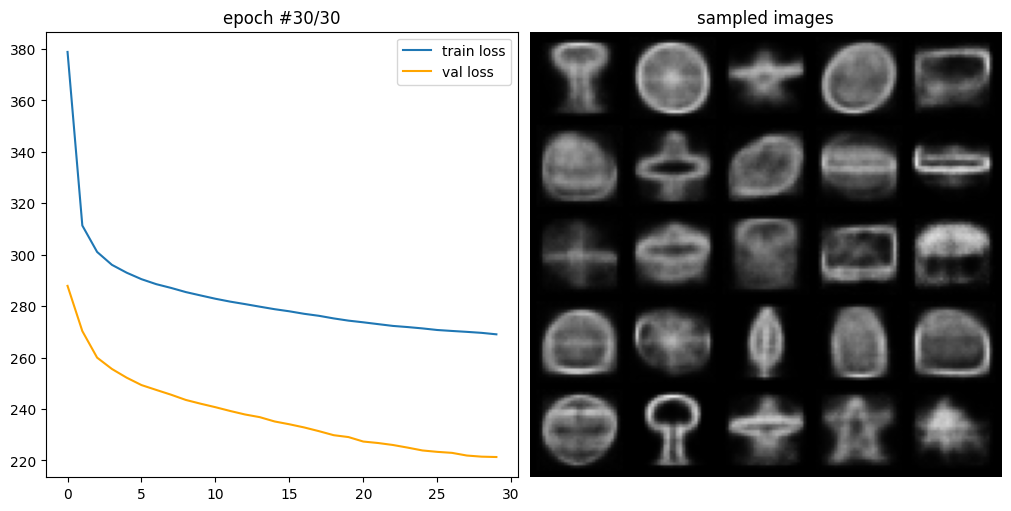

In [ ]:
train_vae(
    model=model,
    n_epochs=30,
    optimizer=optimizer,
    device=DEVICE
)

  0%|          | 0/1 [00:00<?, ?it/s]

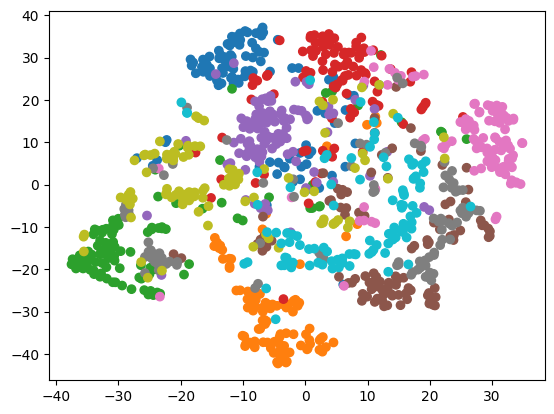

In [ ]:
plot_test_clusters(
    model=model,
    device=DEVICE
)

One can try to use **VAE** as a generator for different variations of same class:

In [ ]:
@torch.no_grad()
def sample_triangles(n_samples=5, std_factor=1):
    plt.figure(figsize=(8, 8))

    model.eval()

    buffer = []

    # all triangle samples
    for i in np.where(val_dataset.labels == 1)[0]:

        sample = val_dataset[i][0].unsqueeze(0)

        buffer.append(sample)

    batch = torch.stack(buffer)

    mean_latent = model.get_latent(sample.to(DEVICE)).detach().cpu().mean(0, keepdim=True)
    buffer = []

    for i in range(n_samples):

        latent = mean_latent + std_factor * torch.randn_like(mean_latent)

        reconstruction = (torch.tanh(model.decoder(latent.to(DEVICE))).cpu() + 1) / 2

        buffer.append(reconstruction)

    recs_tensor = torch.stack(buffer)

    grid = make_grid(recs_tensor.reshape(n_samples, 1, 28, 28), nrow=5).permute(1, 2, 0)

    plt.imshow(grid, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()

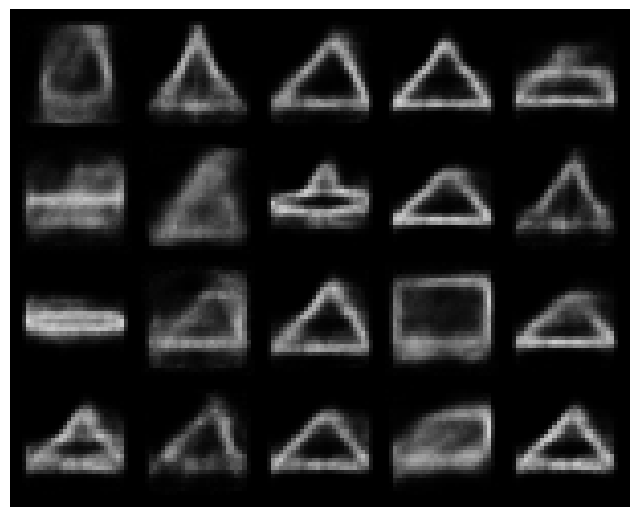

In [ ]:
sample_triangles(n_samples=20)

### 1.3.5 Latent space interpolation

Recall our requirement of regularity? Let's check it

If our latent space is regular, then we can find a path in latent space, which allows for smooth transition between clusters

In [ ]:
model.eval()
pass

In [ ]:
dataset.class_names

array(['star', 'triangle', 'tree', 'airplane', 'snowflake', 'face', 'van',
       'pizza', 'leaf', 'cake'], dtype='<U9')

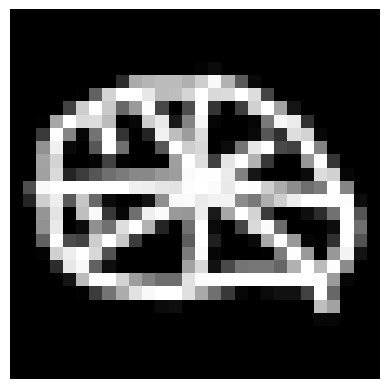

torch.Size([1, 64])

In [ ]:
pizza_id = np.where(val_dataset.labels == 7)[0][0]

plt.axis('off')
plt.imshow(val_dataset[pizza_id][0].reshape(28, 28, 1), cmap='gray')
plt.show()

latent_pizza = model.get_latent(val_dataset[pizza_id][0].unsqueeze(0).to(DEVICE)).detach().cpu()
latent_pizza.shape

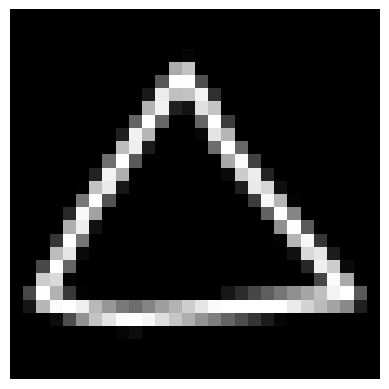

torch.Size([1, 64])

In [ ]:
triangle_id = np.where(val_dataset.labels == 1)[0][0]

plt.axis('off')
plt.imshow(val_dataset[triangle_id][0].reshape(28, 28, 1), cmap='gray')
plt.show()

latent_triangle = model.get_latent(val_dataset[triangle_id][0].unsqueeze(0).to(DEVICE)).detach().cpu()
latent_triangle.shape

In [ ]:
@torch.no_grad()
def show_latent_path(path_len):
    plt.figure(figsize=(8, 8))

    model.eval()

    alpha_arr = 1 - torch.linspace(start=0, end=1, steps=2+path_len)

    recs_buffer = []

    for alpha in alpha_arr:

        latent = alpha * latent_pizza + (1 - alpha) * latent_triangle

        reconstruction = (torch.tanh(model.decoder(latent.to(DEVICE))).cpu() + 1) / 2

        recs_buffer.append(reconstruction)

    recs_tensor = torch.stack(recs_buffer)

    grid = make_grid(recs_tensor.reshape(2+path_len, 1, 28, 28), nrow=5).permute(1, 2, 0)

    plt.imshow(grid, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()

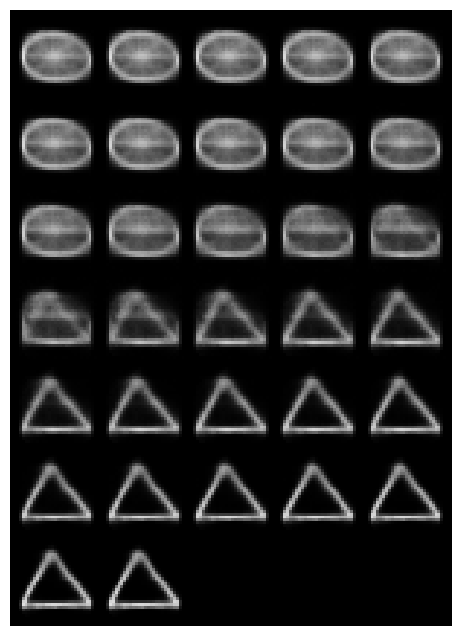

In [ ]:
show_latent_path(30)

Woohoo!

___